## Load data

In [3]:
import os
import glob
# images are divided up into vehicle and no vehicle folders
# locate vehicle images
basedir = "vehicles/"
# Different folders represent different sources for images e.g GTI,kitti
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+"/*"))
print("number of vehicle image found:" , len(cars))
with open("cars.txt","w")as f:
    for fn in cars:
        f.write(fn+"\n")
        
# locate non_vehicle images
basedir = "non-vehicles/"
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+"/*"))
print("number of non-vehicle image found:" , len(notcars))
with open("cars.txt","w")as f:
    for fn in notcars:
        f.write(fn+"\n")


number of vehicle image found: 8792
number of non-vehicle image found: 8968


## Import libraries 

In [5]:
# Import libraries 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage.measurements import label
import pandas as pd

%matplotlib inline

## Functions to extract features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),  orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion to YCrCb
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
   
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features
def single_image_features(image, cspace='RGB', spatial_size=(32, 32),hist_bins=32, 
                          orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                          spatial_feat=True,hist_feat=True, hog_feat=True, vis=False, horlen=(), lenBool=False):
# extracts a selection of spatial, histogram and hog features from a single image
    img_features = []
    if cspace != 'RGB' and cspace != 'Composite':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'Composite':
            ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            feature_image = np.stack((ycrcb[:,:,0],yuv[:,:,1],hls[:,:,2]),axis=2)    
    else: 
        feature_image = np.copy(image)      
    
    spatial_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    hist_features = []
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    hog_features = []
    if hog_feat == True:
        if hog_channel == 'ALL':            
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)	
             
        img_features.append(hog_features)
    
    horLen = (len(spatial_features),len(hist_features),len(hog_features))
    
    if vis == True and lenBool == False:
        return np.concatenate(img_features), hog_image
    elif vis == False and lenBool == True:
        return np.concatenate(img_features), horLen
    elif vis == True and lenBool == True:
        return np.concatenate(img_features), hog_image, horLen
    else:
        return np.concatenate(img_features)
        
def visualize(gif, rows, cols, imgs, titles):
# plots images in a list     
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3 :
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Visualize a random image

C:\Users\user\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


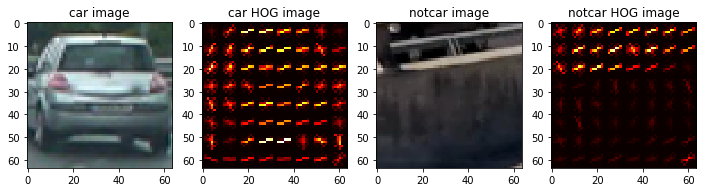

In [9]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (32, 32)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_image_features(car_image, cspace=color_space, spatial_size=spatial_size,
                                                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_image_features(notcar_image, cspace=color_space, spatial_size=spatial_size,
                                                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles=['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)



### Define right parameters to extract features

In [10]:
# Define HOG parameters
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# Spatial size and histogram parameters
spatial_size=(16, 16)
hist_bins=16

## Extract Feature and Build Classifier

In [43]:


print ('Extracting car features')
car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print ('Extracting not-car features')
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',spatial_size, 'spatial_size' , hist_bins, 'hist_bins')
print('HOG: Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Extracting car features


C:\Users\user\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extracting not-car features
Using: (16, 16) spatial_size 16 hist_bins
HOG: Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872


### Linear SVC

In [44]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
prediction = svc.predict(X_test[0].reshape(1, -1))
print(round(time.time()-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
pred = svc.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

7.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


,0,1
0,1827,14
1,20,1691


### Linear SVC looking for the best C parameter

In [45]:
from sklearn.model_selection import GridSearchCV
# Use a linear SVC 
svc1 = LinearSVC()
# Check the training time for the SVC
t=time.time()
parameters = {'C': [0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(svc1, parameters)
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
prediction = clf.predict(X_test[0].reshape(1, -1))
pred = clf.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm


128.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


,0,1
0,1828,15
1,19,1690


### MLP Classifier

In [46]:
from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(random_state=1)
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train MLP...')

# Check the score of the MLP
print('Test Accuracy of MLP = ',  round(mlp.score(X_test, y_test),4))


# Check the prediction time for a single sample
t=time.time()
prediction = mlp.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with MLP')

# Visualize a confusion matrix of the predictions
pred = mlp.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

31.604012966156006 Seconds to train MLP...
Test Accuracy of MLP =  0.9944
0.0 Seconds to predict with MLP


,0,1
0,1840,13
1,7,1692


### MLP Classifier with custom settings

In [15]:
mlp1=MLPClassifier(hidden_layer_sizes=10,solver='sgd',learning_rate_init=0.01,max_iter=500)
t=time.time()
mlp1.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train MLP...')

# Check the score of the MLP
print('Test Accuracy of MLP = ',  round(mlp1.score(X_test, y_test),4))

# Check the prediction time for a single sample
t=time.time()
prediction = mlp.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with MLP')

# Visualize a confusion matrix of the predictions
pred = mlp1.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

12.578983306884766 Seconds to train MLP...
Test Accuracy of MLP =  0.9901
0.0 Seconds to predict with MLP


,0,1
0,1753,20
1,15,1764


## Extract features and make prediction

In [68]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    draw_img_all_windows = np.copy(img)
    img = img.astype(np.float32)/255
    
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch =  cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            test_prediction = svc.decision_function(test_features) #for SVC Classifier
            #test_prediction = (test_features-clf.predict(test_features)).all() # for MLP classifier
 
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img_all_windows,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
            
            
            #if test_prediction > 0: # for MLP Classifier
            if test_prediction > 0: # for SVC Classifier
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bbox_list, draw_img, draw_img_all_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Test SVC on test images

C:\Users\user\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


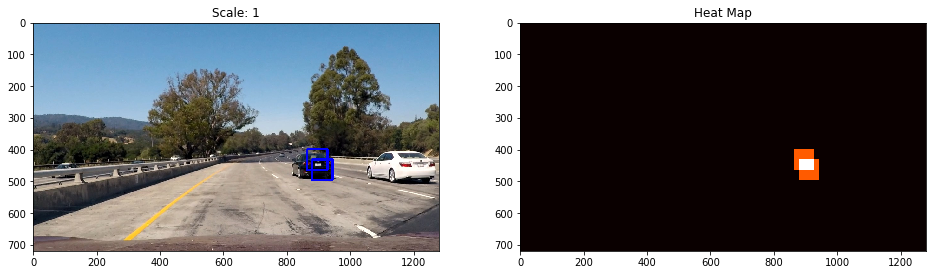

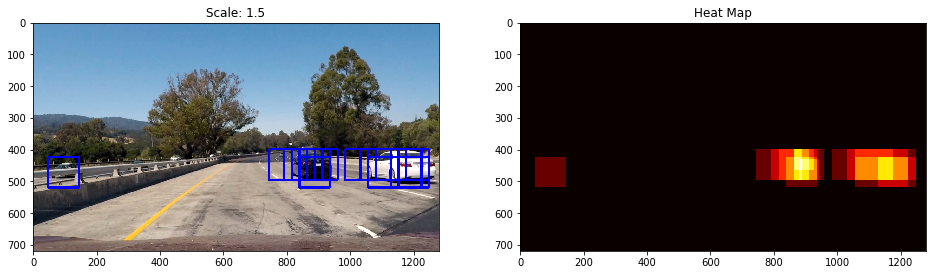

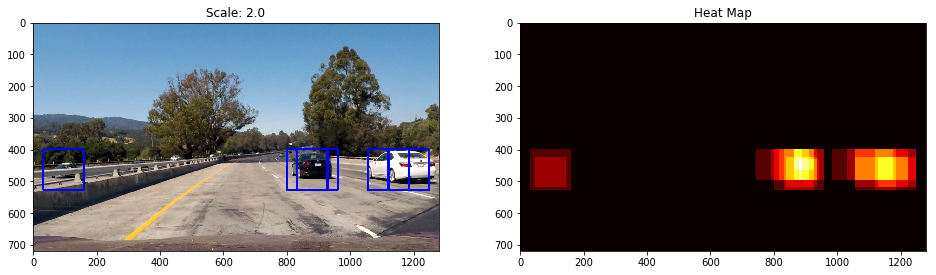

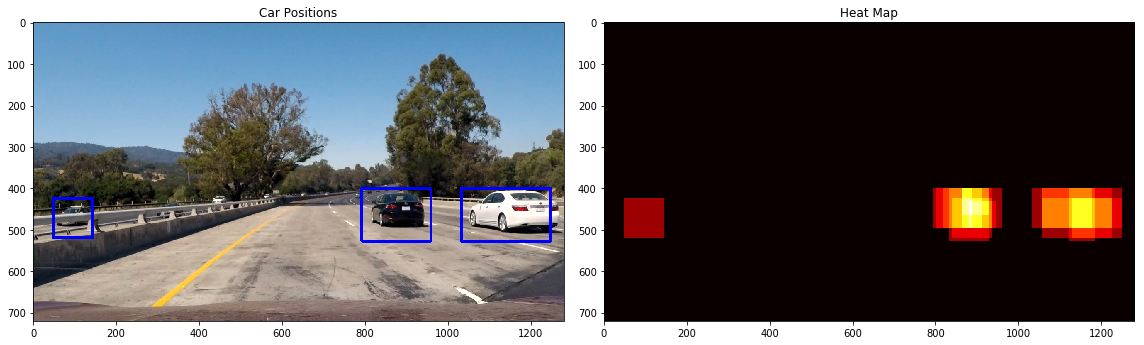

In [56]:
# Read an image to test
img = mpimg.imread('test_images/test1.jpg')
# Create the heat map
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Define ROI of the images where to use the sliding windows
ystart = 400
ystop = 656

# Look for cars at different scales
scales = [ 1, 1.5,2.0]

for scale in scales:
    box_list,out_img,out_img_windows  = find_cars(img, ystart, ystop, scale,svc, X_scaler, orient, pix_per_cell,
                                                  cell_per_block, spatial_size, hist_bins)
    heat = add_heat(heat,box_list)
    
    fig = plt.figure(figsize = (16,16))
    plt.subplot(121)
    plt.imshow(out_img)
    caption = 'Scale: ' +  str(scale)
    plt.title(caption)
    plt.subplot(122)
    plt.imshow(heat, cmap='hot')
    plt.title('Heat Map')

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize = (16,16))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
#fig = plt.figure(figsize = (8,8))
#plt.imshow(out_img_windows)

## Test mlp on test images

C:\Users\user\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


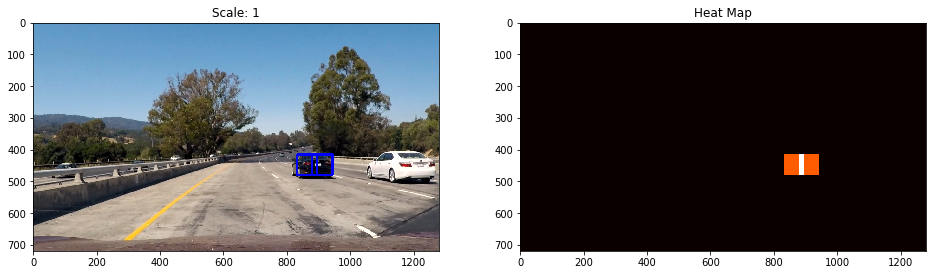

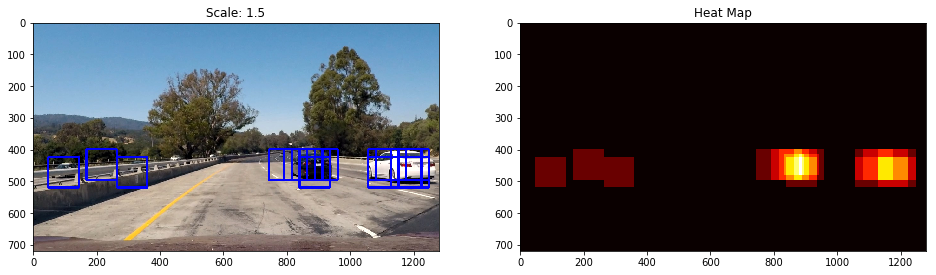

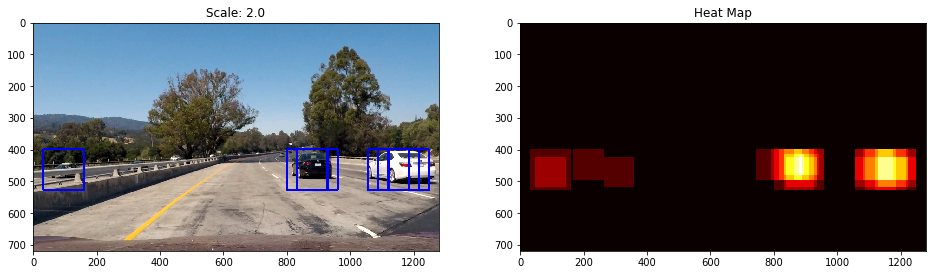

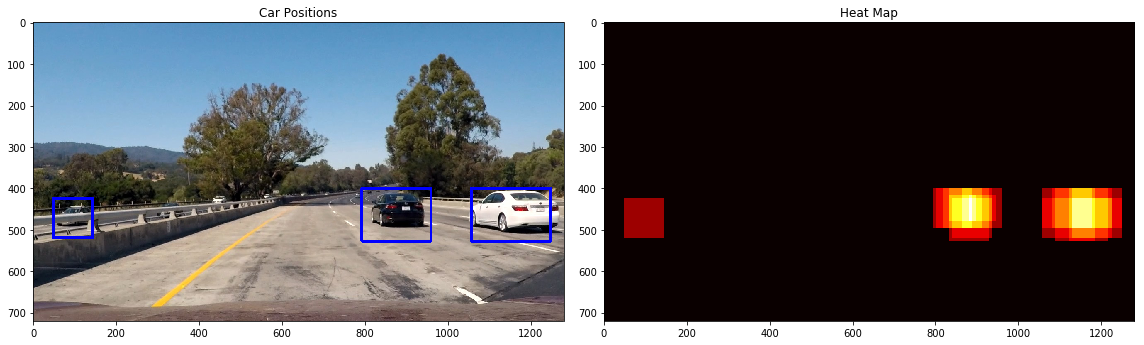

In [65]:
# Read an image to test
img = mpimg.imread('test_images/test1.jpg')
# Create the heat map
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Define ROI of the images where to use the sliding windows
ystart = 400
ystop = 656

# Look for cars at different scales
scales = [1,1.5, 2.0]

for scale in scales:
    box_list,out_img,out_img_windows  = find_cars(img, ystart, ystop, scale, mlp, X_scaler, orient, pix_per_cell,
                                                  cell_per_block, spatial_size, hist_bins)
    heat = add_heat(heat,box_list)
    
    fig = plt.figure(figsize = (16,16))
    plt.subplot(121)
    plt.imshow(out_img)
    caption = 'Scale: ' +  str(scale)
    plt.title(caption)
    plt.subplot(122)
    plt.imshow(heat, cmap='hot')
    plt.title('Heat Map')

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize = (16,16))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
#fig = plt.figure(figsize = (8,8))
#plt.imshow(out_img_windows)

## Test  video using MLP Classifier

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import collections

heatmaps = collections.deque(maxlen=29)

def process_image(img):
    global heatmaps

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    ystarts = [400,350,350]
    ystops = [656,570,570]
    
    # Look for cars at different scales
    scales = [1., 1.5, 2.0]

    for scale, ystart, ystop  in zip(scales,ystarts,ystops):
        box_list,out_img,out_img_windows  = find_cars(img, ystart, ystop, scale, mlp, X_scaler, orient, pix_per_cell,
                                                      cell_per_block, spatial_size, hist_bins)
        heat = add_heat(heat,box_list)
    # Append heatmap and compute the sum of the last n ones
    heatmaps.append(heat)
    sum_heatmap = np.array(heatmaps).sum(axis=0)
    # Apply the threshold to remove false positives
    heat = apply_threshold(sum_heatmap, min(len(heatmaps) * 1, 28))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

video_output = 'MLP_project_video_out.mp4'
clip2 = VideoFileClip('project_video.mp4')

video_clip = clip2.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video MLP_project_video_out.mp4
[MoviePy] Writing video MLP_project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [46:17<00:02,  2.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: MLP_project_video_out.mp4 

Wall time: 46min 18s


In [70]:
from IPython.display import HTML
video_output = 'MLP_project_video_out.mp4'
print(video_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

MLP_project_video_out.mp4


## Test video using SVC Classifier

In [69]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import collections

heatmaps = collections.deque(maxlen=29)

def process_image(img):
    global heatmaps

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    ystarts = [400,350,350]
    ystops = [656,570,570]
    
    # Look for cars at different scales
    scales = [1., 1.5, 2.0]

    for scale, ystart, ystop  in zip(scales,ystarts,ystops):
        box_list,out_img,out_img_windows  = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                                                      cell_per_block, spatial_size, hist_bins)
        heat = add_heat(heat,box_list)
    # Append heatmap and compute the sum of the last n ones
    heatmaps.append(heat)
    sum_heatmap = np.array(heatmaps).sum(axis=0)
    # Apply the threshold to remove false positives
    heat = apply_threshold(sum_heatmap, min(len(heatmaps) * 1, 28))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

video_output = 'SVC_project_video_out.mp4'
clip2 = VideoFileClip('project_video.mp4')

video_clip = clip2.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video SVC_project_video_out.mp4
[MoviePy] Writing video SVC_project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [34:59<00:01,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: SVC_project_video_out.mp4 

Wall time: 35min


In [71]:
from IPython.display import HTML
video_output = 'SVC_project_video_out.mp4'
print(video_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

SVC_project_video_out.mp4
